In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grdevices
from IPython.display import Image, display
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

base = importr('base')
mvts = importr('mvtsplot')

In [4]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [5]:
# Extract seasons
seasons = {season: data for season, data in list(nc.seaice_conc.groupby('time.season'))}

In [6]:
# Resample to get yearly averages across all seasons
seasons = {season: data.resample('AS', dim='time', how='mean') for season, data in seasons.items()}

In [7]:
# Convert to dataframe
dfs = {season: data.to_dataframe().reset_index() for season, data in seasons.items()}

# Remove land
dfs = {season: df[df['seaice_conc'] >= 0] for season, df in dfs.items()}

# Remove latitude values less than 50 degrees (where ~1% of seaice_conc are nonzero)
dfs = {season: df[df['latitude'] >= 50] for season, df in dfs.items()}

In [8]:
# Extract timeseries for DJF
djf_series = {(lat, lon): df for lat, latdf in list(dfs['DJF'].groupby('latitude'))
                             for lon, df in list(latdf.groupby('longitude'))}

In [9]:
# # Plot a couple series
# plt.figure(figsize=(16,12))
# eps = 0
# for latlon, series in djf_series.items():
#     if eps > 100500 and eps < 100506:
#         #plt.plot(series['time'], series['seaice_conc'], label=str(latlon))
#         pass
#     if eps > 125058 and eps < 125064:
#         #plt.plot(series['time'], series['seaice_conc'], label=str(latlon))
#         pass
#     if eps > 81200 and eps < 81205:
#         #plt.plot(series['time'], series['seaice_conc'], label=str(latlon))
#         #pass
#     eps += 1
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylabel('seaice_conc')
# plt.xlabel('Year')

In [10]:
djf_dfs = []
djf_lls = []
for ll, d in djf_series.items():
    djf_dfs += [d.seaice_conc.values[np.newaxis].T]
    djf_lls += [str(ll)]
    
Xdjf = np.hstack(djf_dfs)
Xr = ro.r.matrix(Xdjf, nrow=Xdjf.shape[0], ncol=Xdjf.shape[1])
ro.r.assign("Xdjf", Xr)
Xr.colnames = ro.StrVector(djf_lls)

In [11]:
def plot_mvts(x, norm="internal"):
    with grdevices.render_to_bytesio(grdevices.png,width=2048,height=2048,res=300) as img:
        mvts.mvtsplot(x, norm=norm)
    display(Image(data=img.getvalue(), format='png', embed=True))

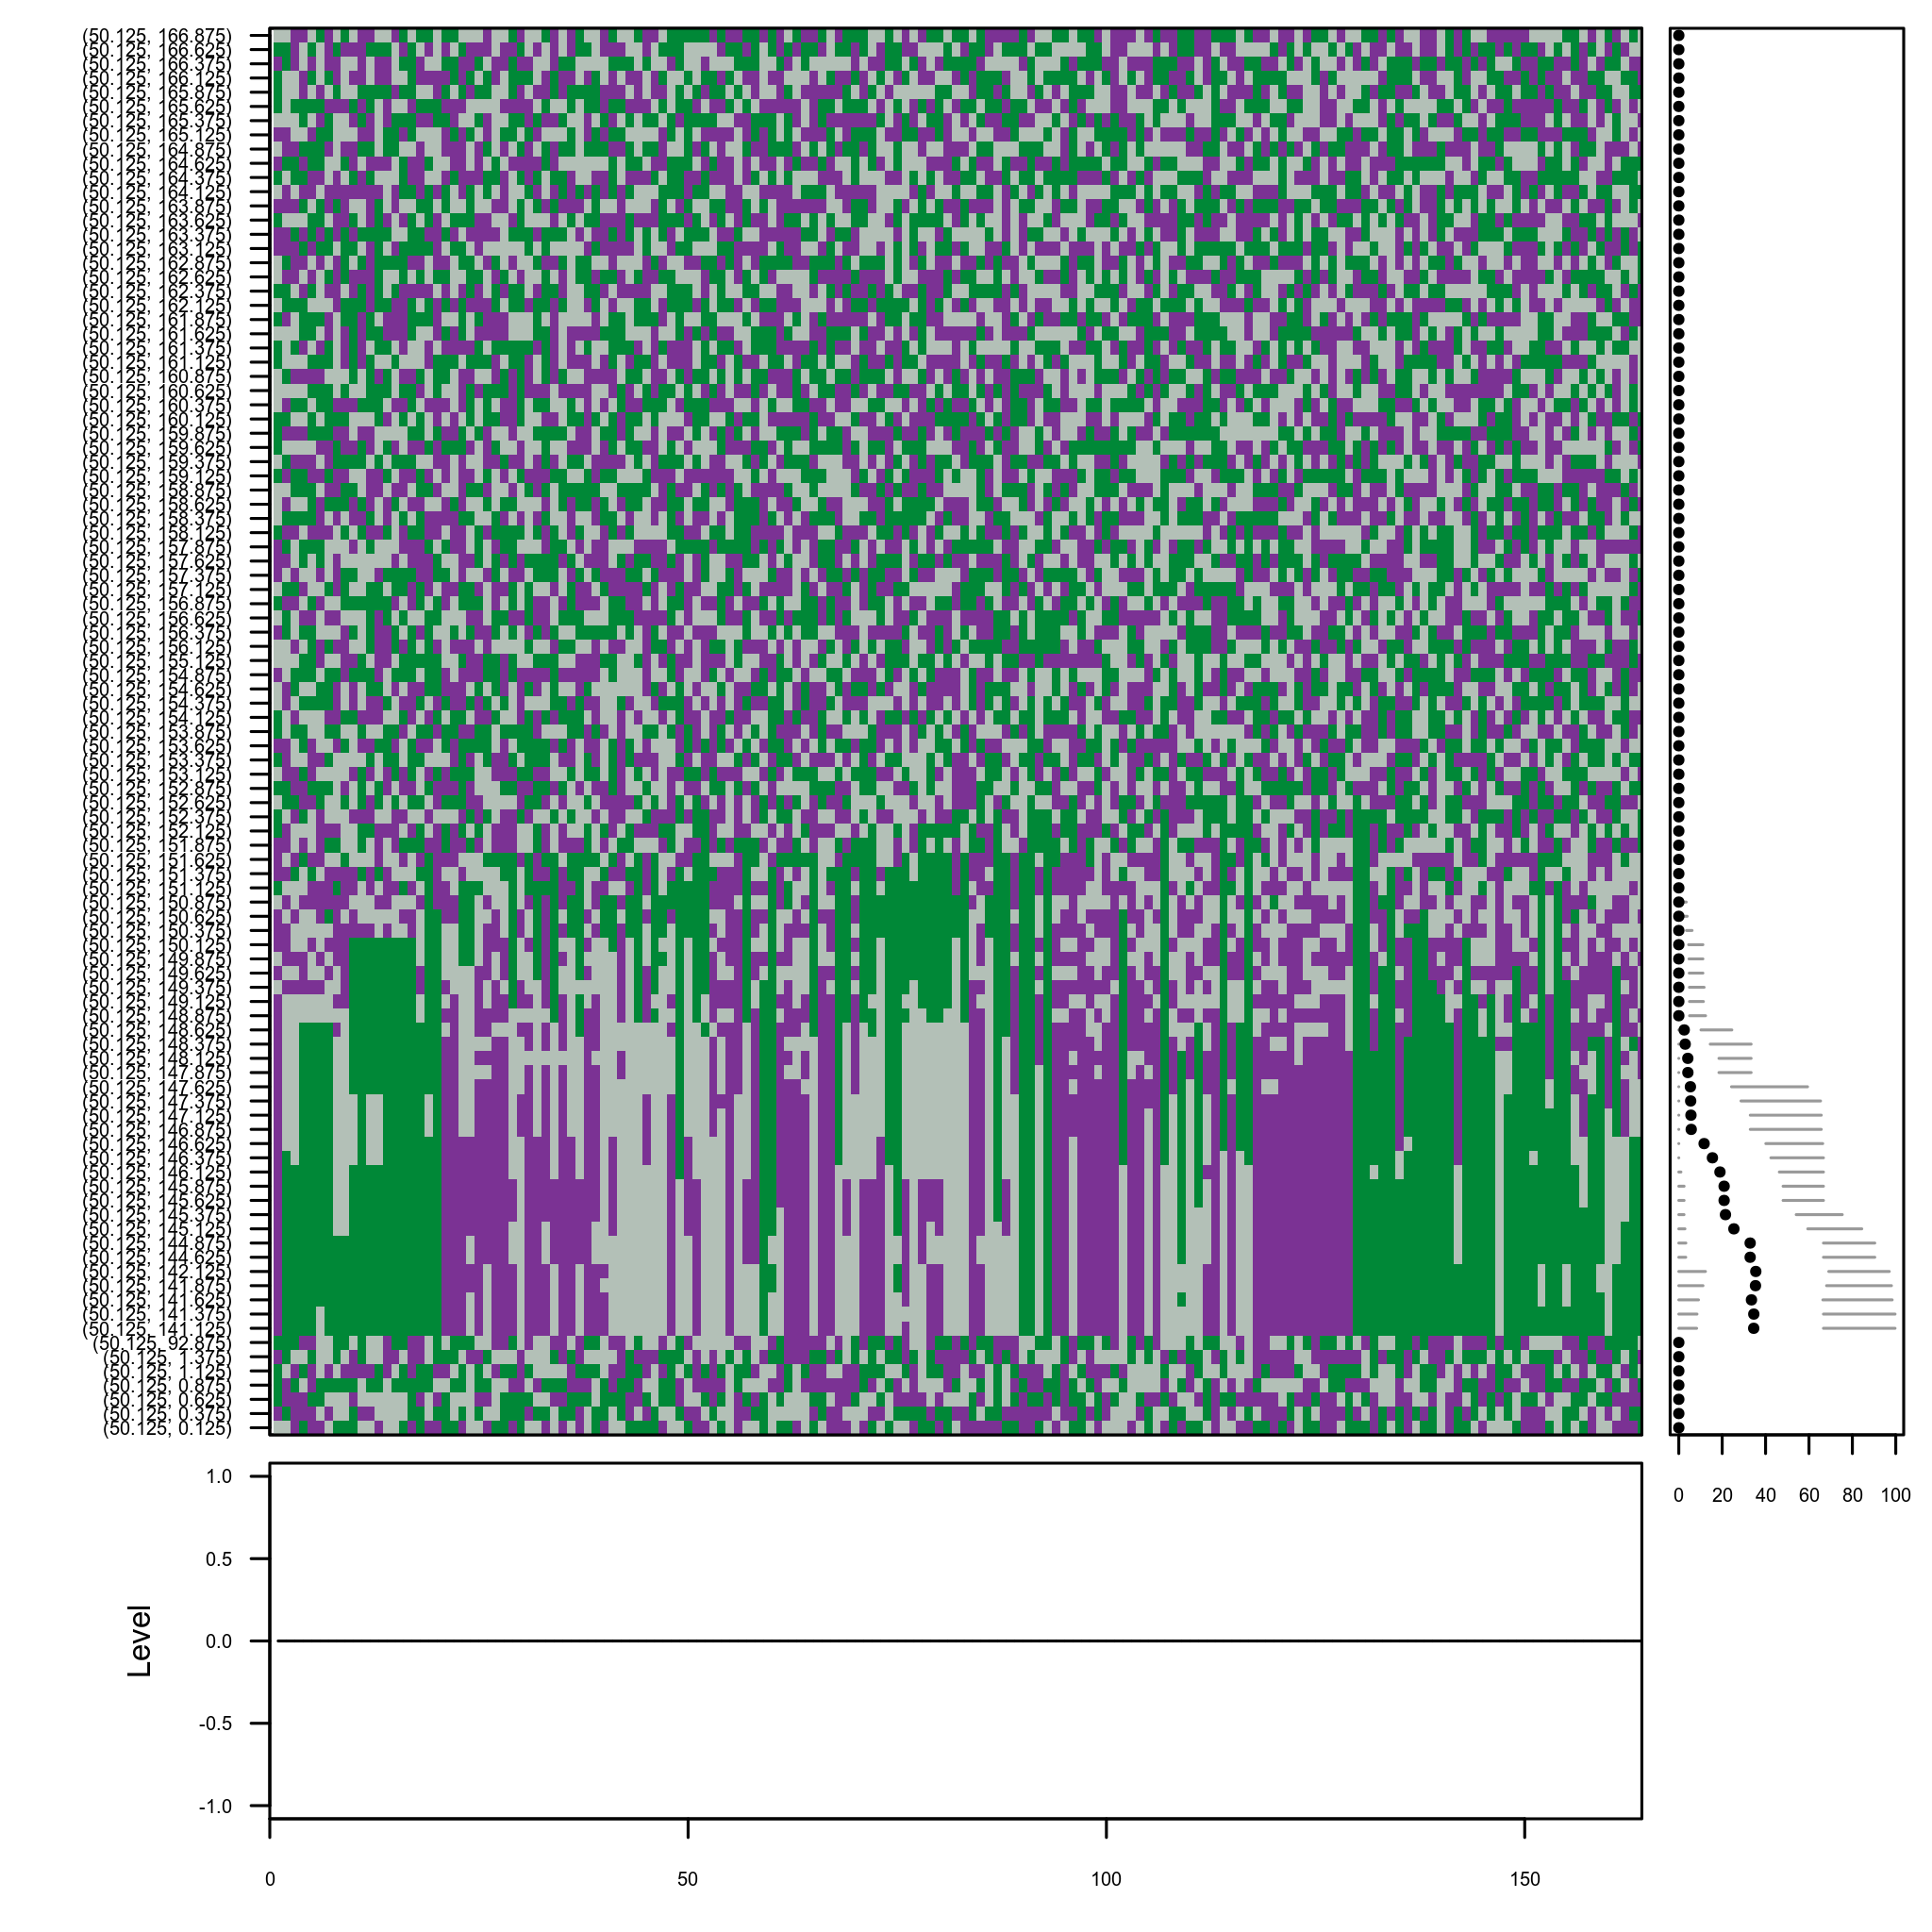

In [12]:
X50 = Xr.rx(True, ro.IntVector(list(range(1,100))))
plot_mvts(X50)

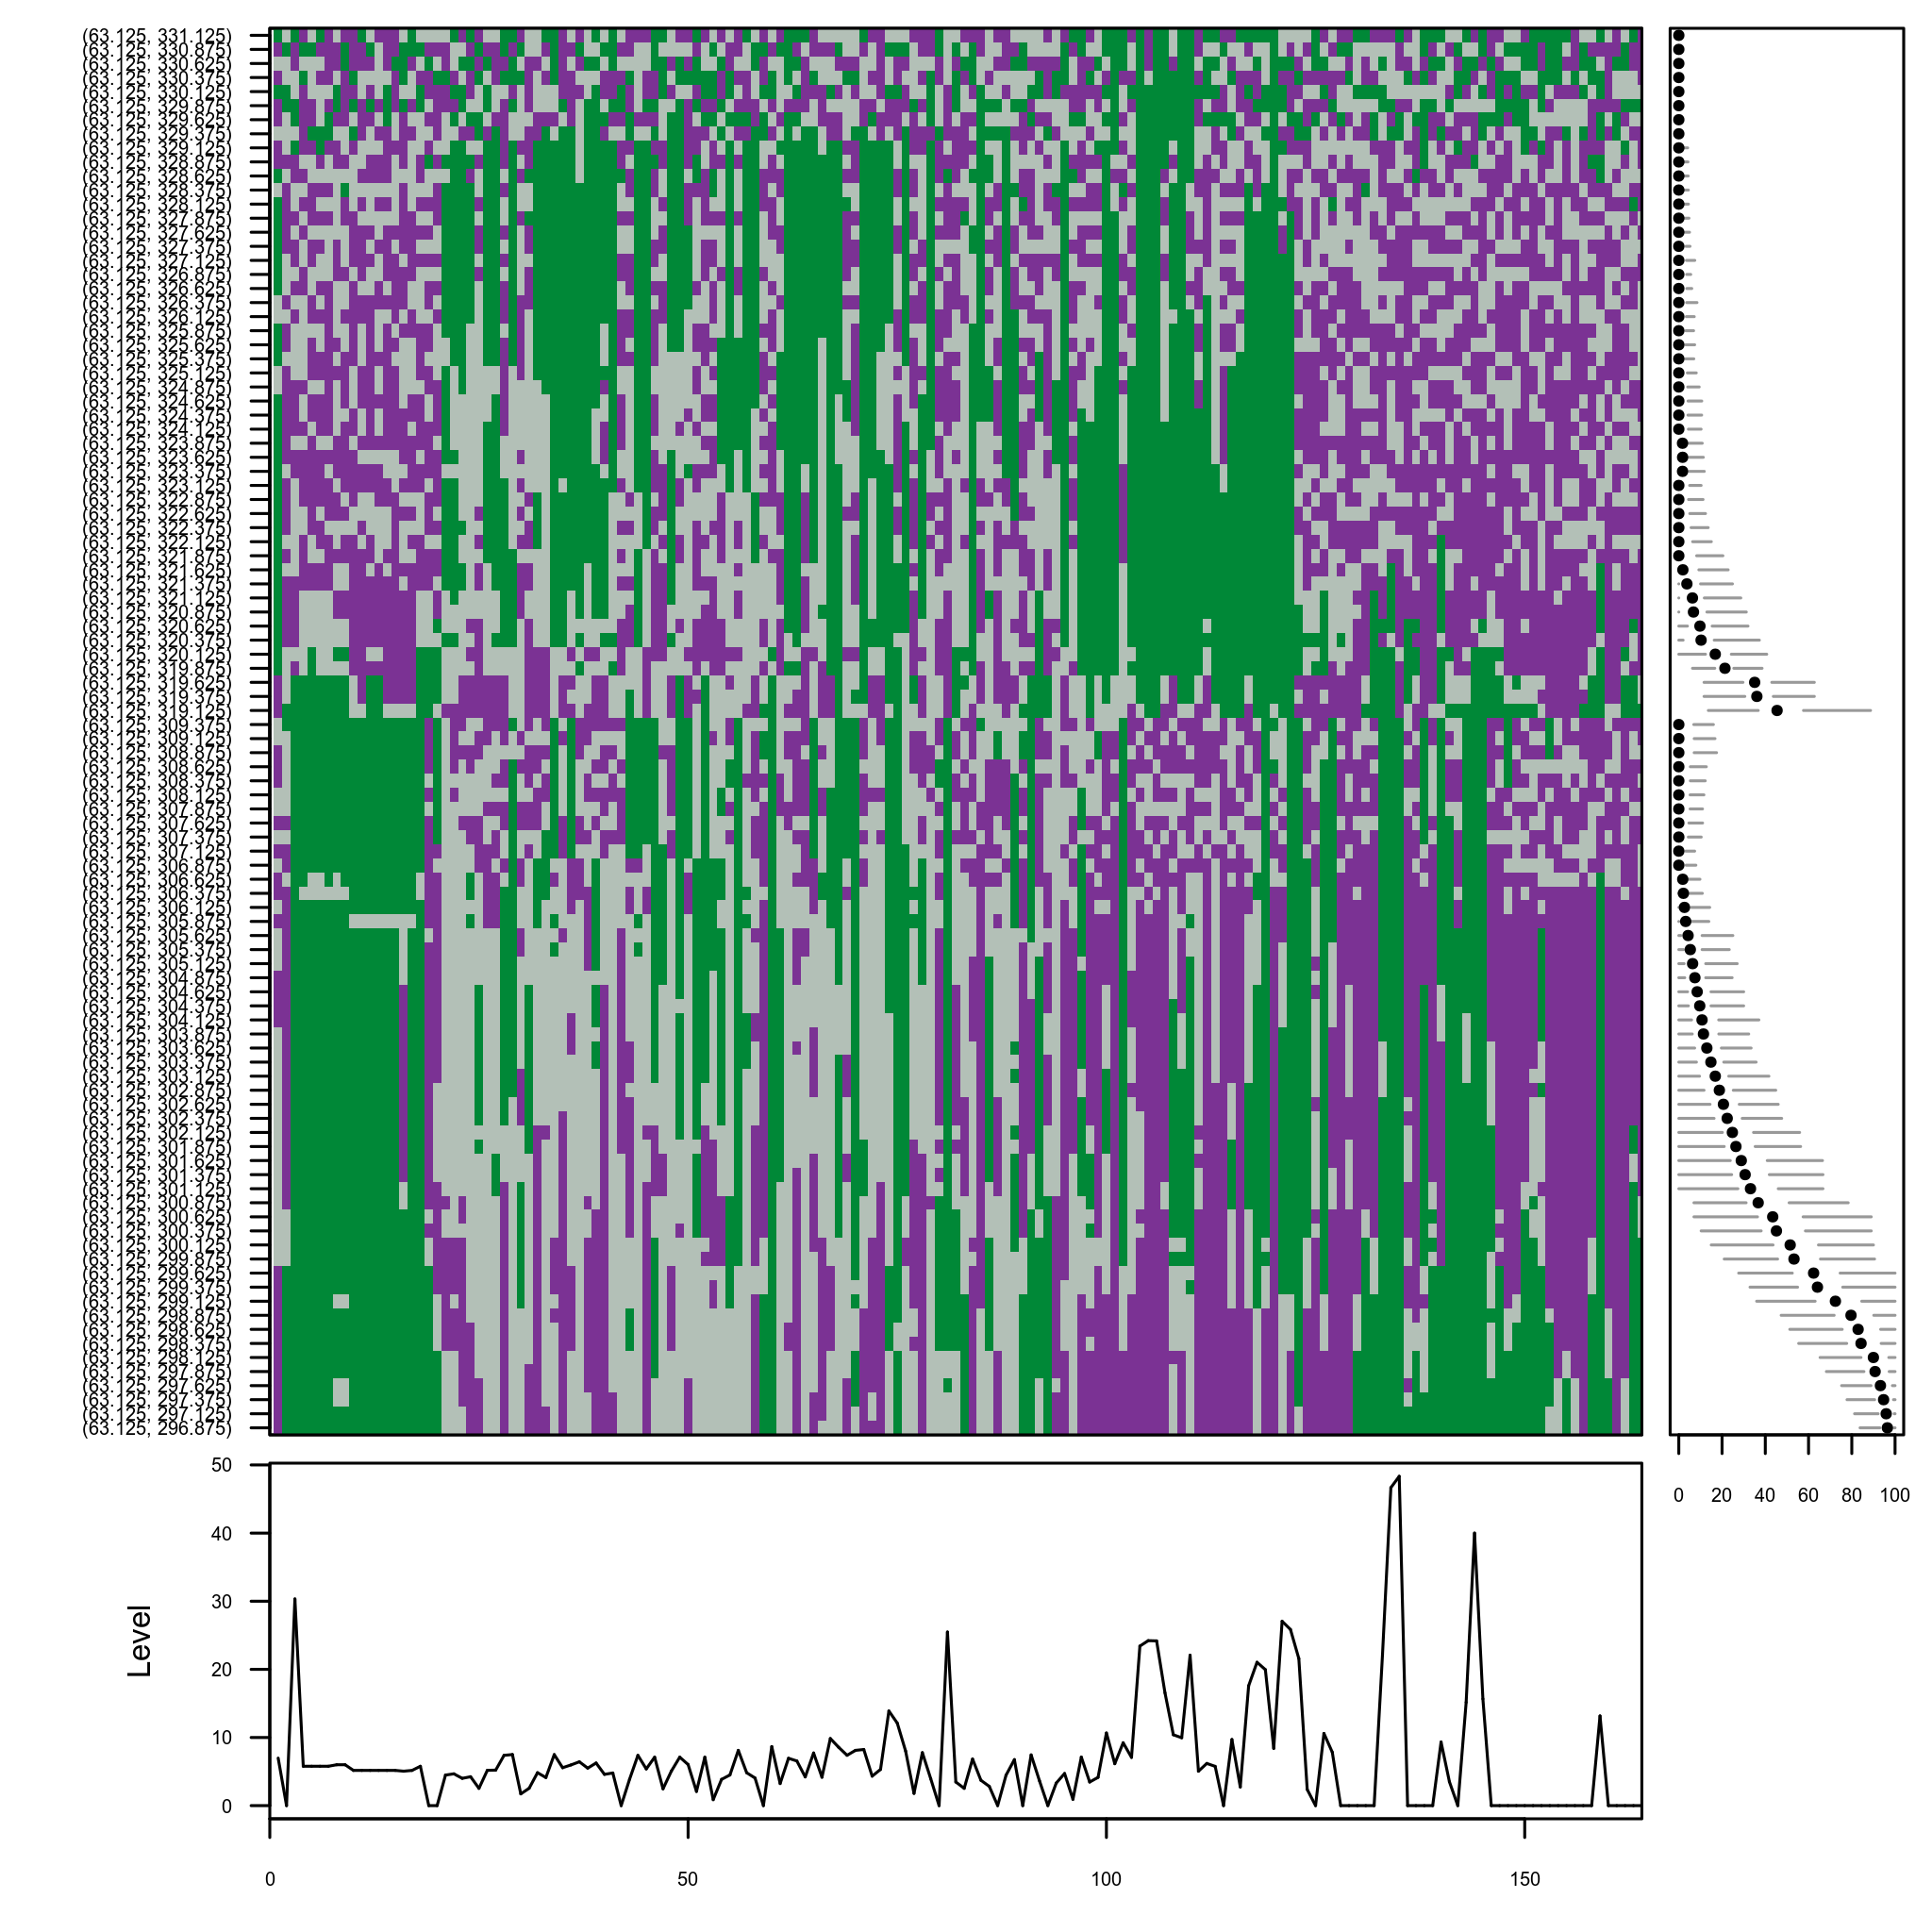

In [13]:
X63 = Xr.rx(True, ro.IntVector(list(range(30000,30100))))
plot_mvts(X63)

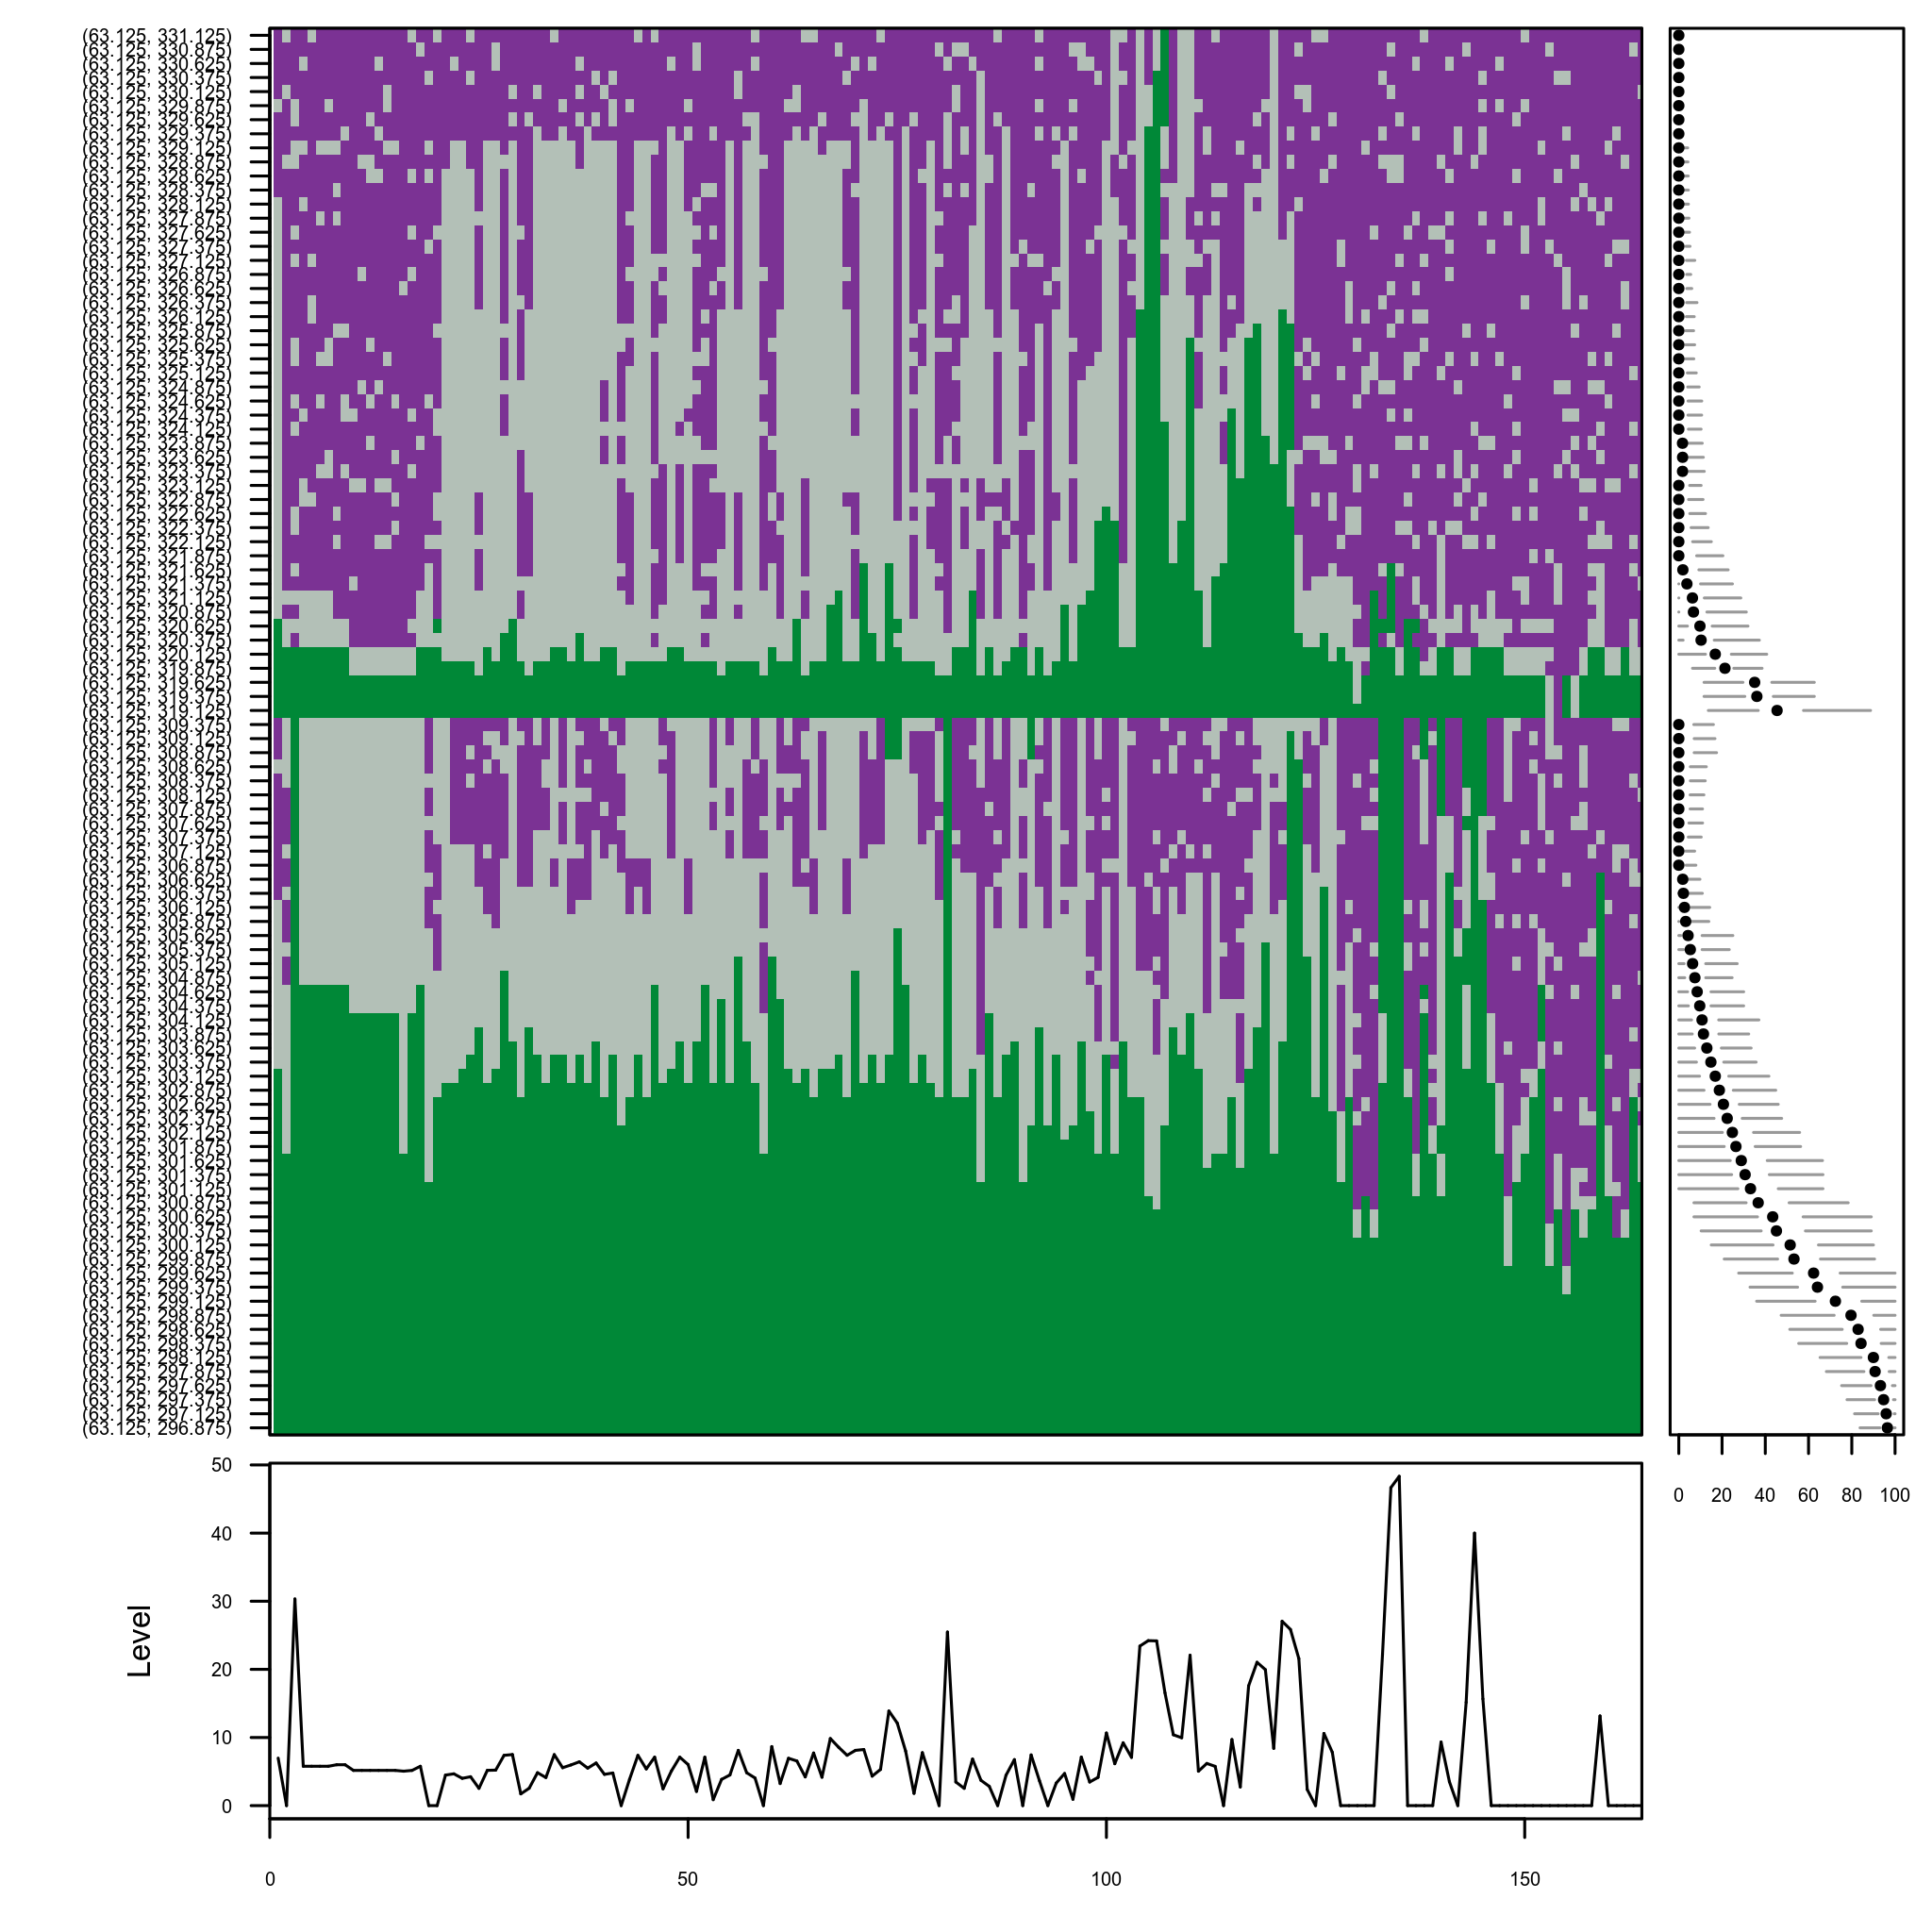

In [14]:
plot_mvts(X63, norm="global")

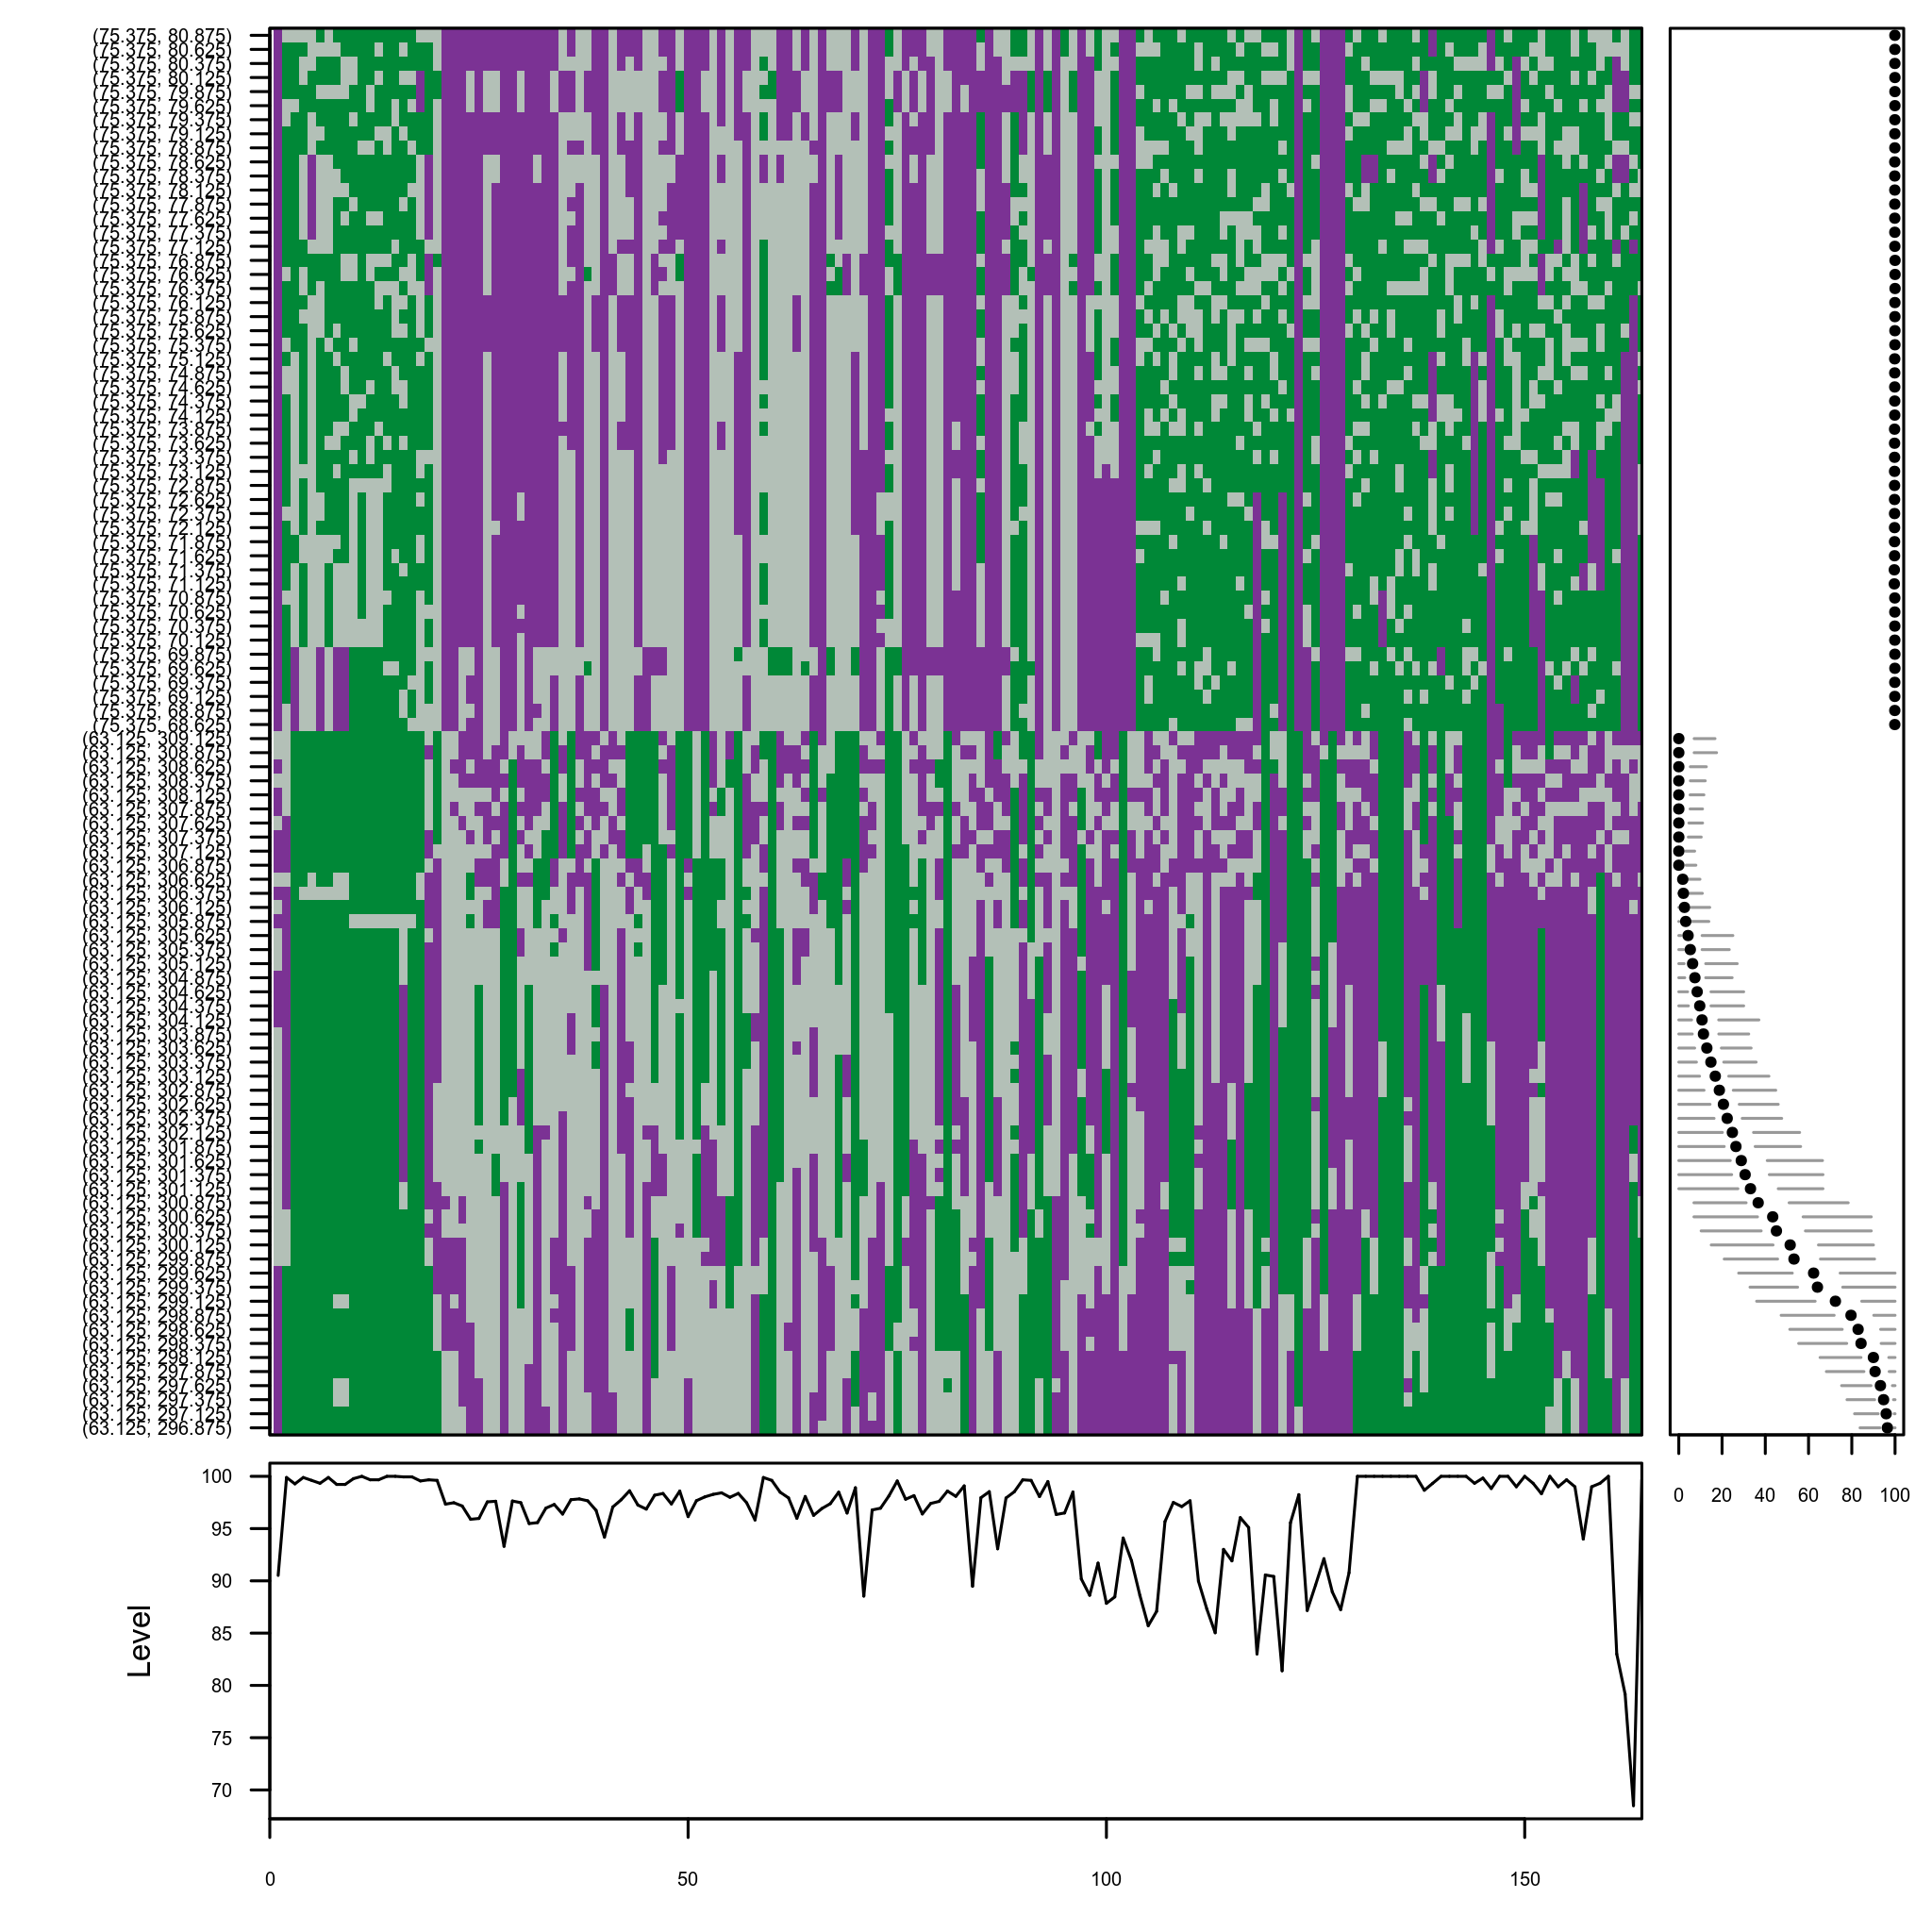

In [15]:
idxs = list(range(30000, 30050)) + list(range(60000, 60050))
X63vs75 = Xr.rx(True, ro.IntVector(idxs))
plot_mvts(X63vs75)

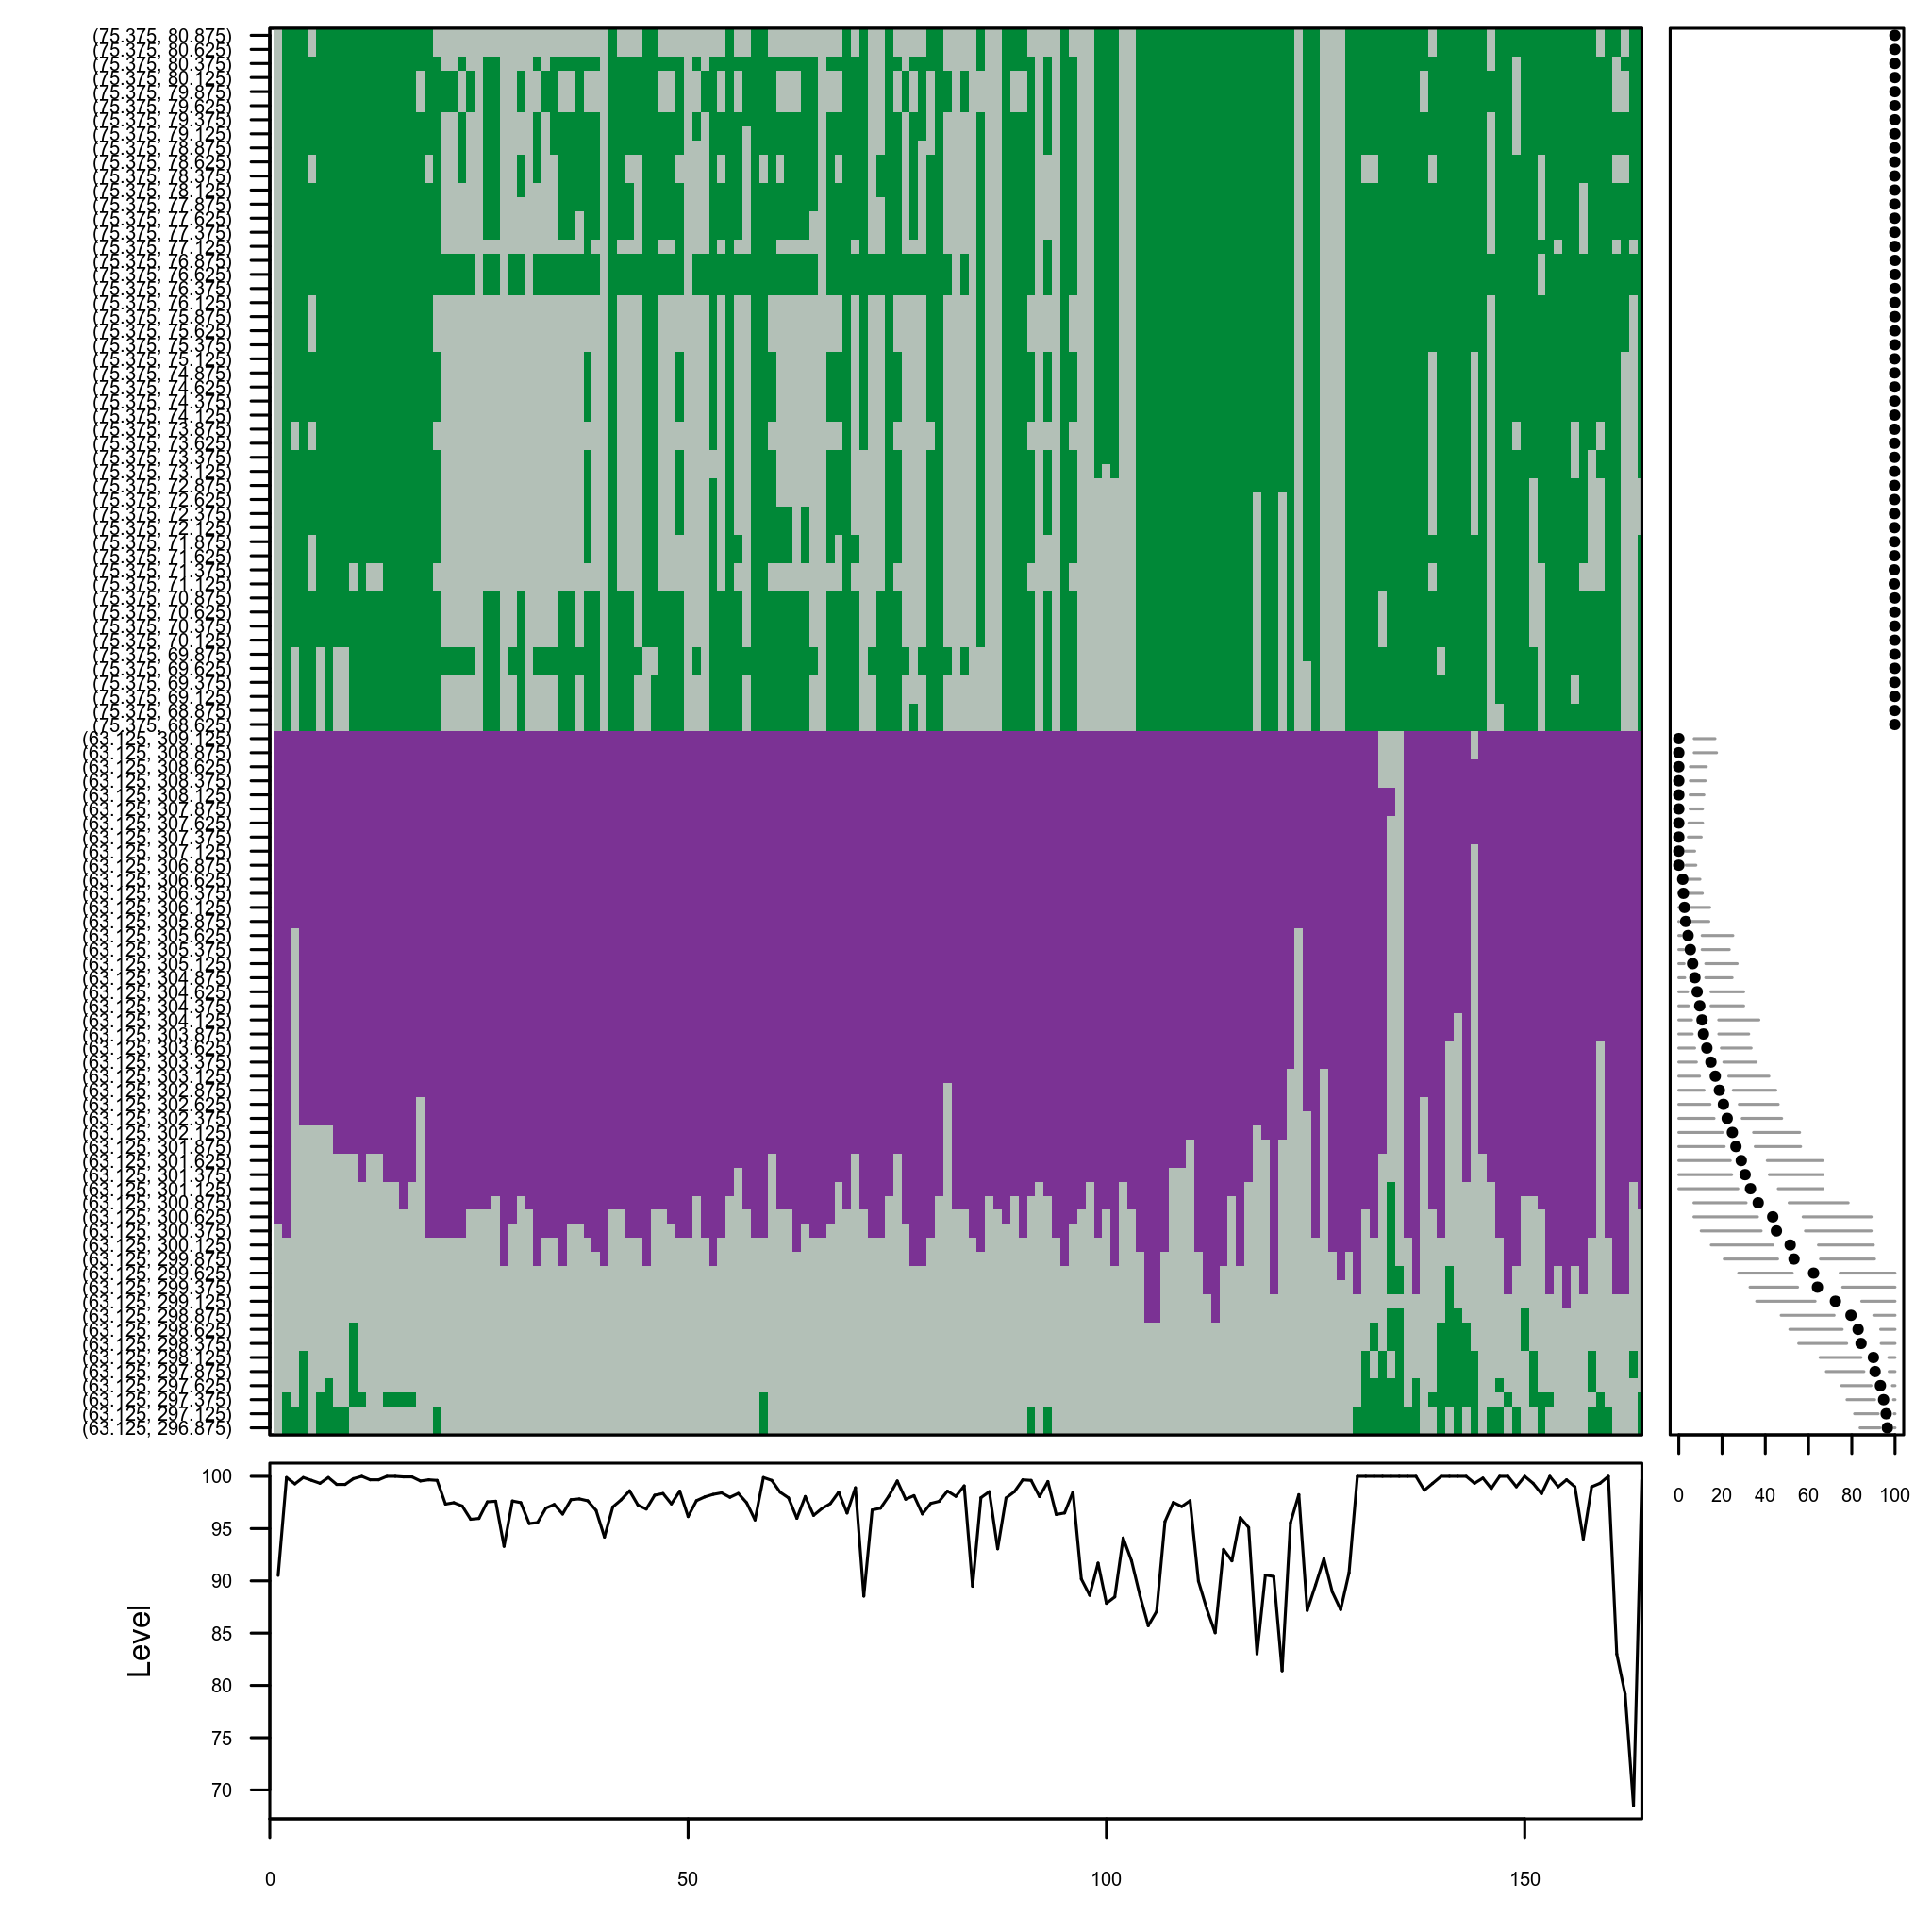

In [16]:
plot_mvts(X63vs75, norm="global")